# Experiments expanding on Ito et al. (2017)


In [1]:
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm

## Import custom modules
# Primary module with most model functions
import model
# Module for FC regression
import multregressionconnectivity as mreg

## Experiment 1: GLM recovery of simulated task activity using information flow


### Create network

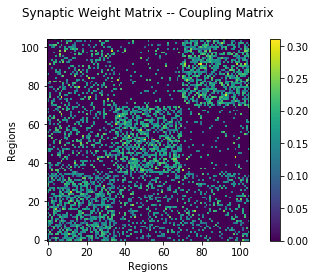

In [2]:
#### Set up subject network matrix ####
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

### Simulate resting state activity using information flow model

Apply neural networl model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point

**Note that this is still in synaptic space (i.e. not convolved)**

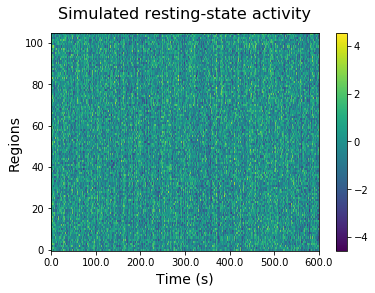

In [3]:
## Set up simulation parameters
Tmaxrest = 60000
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0
TRLength = 100

restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)

plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmaxrest+1,10000),np.arange(0,Tmaxrest+1,10000)/100)
plt.colorbar()

### Convolve resting state activity

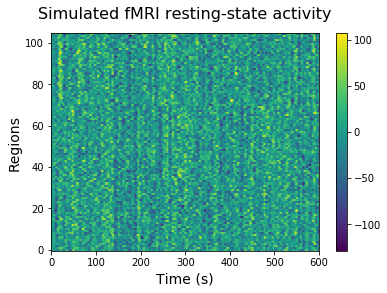

In [4]:
restfmri = model.convolveTimeseries(restdata,
                                    samplingrate=dt,
                                    TRLength=TRLength)
plt.figure()
plt.imshow(restfmri, aspect='auto',origin='lower')
plt.title('Simulated fMRI resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Recover connectivity matrix from resting state activity

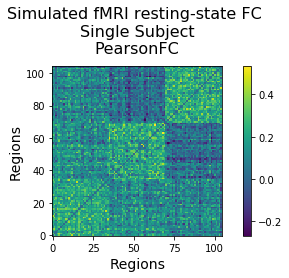

In [5]:
fcmat = np.corrcoef(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat,0)

plt.figure()
plt.imshow(fcmat, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC \nSingle Subject\nPearsonFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

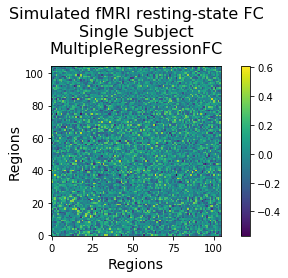

In [6]:
fcmat_mreg = mreg.multregressionconnectivity(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat_mreg,0)

plt.figure()
plt.imshow(fcmat_mreg, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC\nSingle Subject\nMultipleRegressionFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

### Simulate task activity using resting state

- Decide on the stimulus on/off for the I matrix
- How do you decide the task's spatial specificity, i.e. which network and nodes within a network it affects primarily? 
    - In the simulations the approach is: For topdown tasks only the hub network is simulated. E.g. for task 1 the first quarter of nodes are stimulated, for task 2 the next quarter etc. 
    - For topdown and bottom up (where a bug was fixed) it is a bit more complicated. E.g. for task 5 the first quarter of the hub network and the nodes of network 1 (first local network) that connect to the hub network (network 0) are stimulated
- Use model.networkmodel with G weights matrix and I task matrix

**For this example starting with a single top down task**

In [7]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 10000

T = np.arange(0,Tmax,dt)

taskdata = {}
stimtimes = {}
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

topdown_only = range(1,5)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

for t in range(len(T)):
    if tasktiming[0,t] == 1:
        # Task stimulation every 10 seconds for 4 seconds, excluding the first 10 seconds
        stimtimes[task][stim_nodes,t] = .5

Block design task looks like:

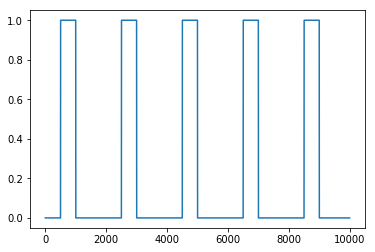

In [8]:
plt.plot(T, tasktiming[0])

Activated nodes in the hub network *only* (making it a top-down task) are:

In [9]:
stim_nodes

array([0, 1, 2, 3, 4, 5, 6, 7])

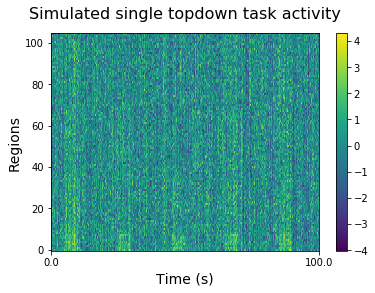

In [10]:
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

plt.figure()
plt.imshow(taskdata[task], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

### Convolve task activity 


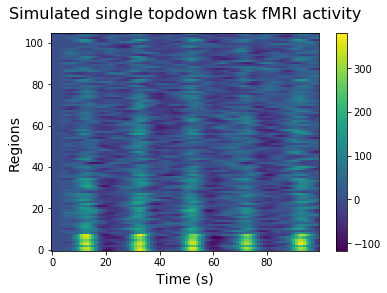

In [11]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
task_bold = model.convolveTimeseries(taskdata[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)
plt.figure()
plt.imshow(task_bold, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Run GLM on convolved task activity

In [12]:
n_skip_BOLD = int(TRLength)
# Temporally downsample task timing to seconds (before convolving)
timingconv = tasktiming[:,::n_skip_BOLD]
timingconv.shape = (timingconv.shape[1],)
hrfsample_rate=1.0 # HRF is sampled at seconds
hrfsample_times = np.arange(0, 30, hrfsample_rate, dtype=float)
hrf_at_simsample = model.hrf(hrfsample_times)
hrfconvtime = np.convolve(timingconv, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = hrfconvtime[:-n_to_remove]
# Output
timing_convolved_downsampled = convolved

In [13]:
task_betas_postfmri, task_resids_postfmri = model.runTaskGLM(task_bold, timing_convolved_downsampled)

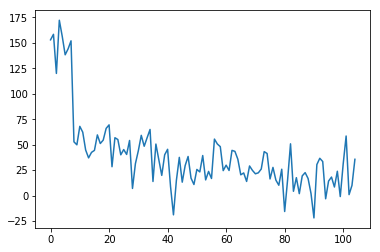

In [14]:
plt.plot(task_betas_postfmri)

### What is the relationship between betas and weights from the connectivity matrix?

Extract average connectivity between each node and the nodes stimulated by task.  
Correlate these average weights with betas for each node.

NOTE: The weight matrix is *NOT* symmetric (I think) because afferent and efferent connection weights need not be the same.

In [46]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(G)

False

In [53]:
task_betas_postfmri.shape

(105,)

Extract average connectivity of each node with the stim nodes

In [19]:
stim_nodes

array([0, 1, 2, 3, 4, 5, 6, 7])

In [71]:
afferent_cons = np.empty((0,G.shape[0]), float)
efferent_cons = np.empty((0,G.shape[0]), float)
both_cons = np.empty((0,G.shape[0]), float)
for i in range(G.shape[0]):
    afferent_cons = np.append(afferent_cons, [G[stim_nodes,i].mean()])
    efferent_cons = np.append(efferent_cons, [G[i,stim_nodes].mean()])
    both_cons = np.append(both_cons, [np.append(G[i,stim_nodes], [G[stim_nodes,i]]).mean()])

Text(0.5, 0, 'Beta')

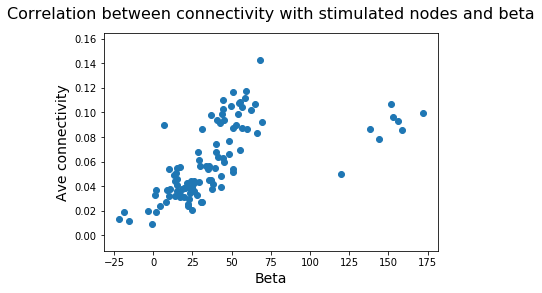

In [74]:
plt.scatter(task_betas_postfmri, both_cons)
plt.title('Correlation between connectivity with stimulated nodes and beta', y=1.04, fontsize=16)
plt.ylabel('Ave connectivity',fontsize=14)
plt.xlabel('Beta',fontsize=14)

Text(0.5, 0, 'Beta')

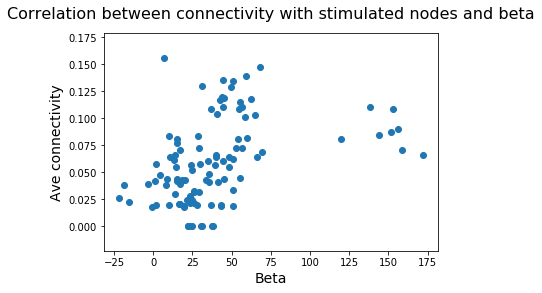

In [75]:
plt.scatter(task_betas_postfmri, afferent_cons)
plt.title('Correlation between connectivity with stimulated nodes and beta', y=1.04, fontsize=16)
plt.ylabel('Ave connectivity',fontsize=14)
plt.xlabel('Beta',fontsize=14)

Text(0.5, 0, 'Beta')

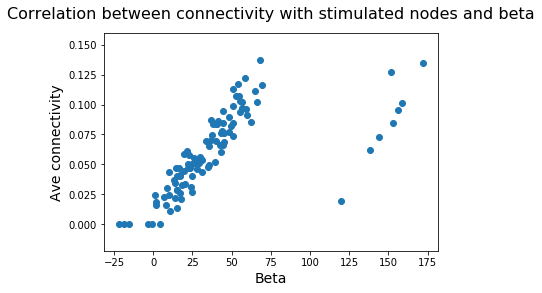

In [77]:
plt.scatter(task_betas_postfmri, efferent_cons)
plt.title('Correlation between connectivity with stimulated nodes and beta', y=1.04, fontsize=16)
plt.ylabel('Ave connectivity',fontsize=14)
plt.xlabel('Beta',fontsize=14)

### [come back later] Predicted task activity using Actflow

Predict activity usings task betas and resting state connectivity **(Eq 7)**

In [ ]:
actflow_mreg = model.computeActFlowBetweenNetworks(fcmat_mreg, 
                                                 task_betas_postfmri, 
                                                 ncommunities, 
                                                 nodespercommunity, posOnly=False)

In [ ]:
ntasks = 1
nblocks = 1
block = 1
actflow_mreg2 = {}
for task in range(1,ntasks+1):
    # Generate empty output variables
    actflow_mreg2[task] = {}
    for i in range(ncommunities):
        actflow_mreg2[task][i] = {}
        for j in range(ncommunities):
            if i==j: continue
            actflow_mreg2[task][i][j] = np.zeros((nodespercommunity,nblocks))

Remove predicted betas generated using the self network (i.e. for the hub network drop predictions for the hub network and keep only the predictions for the other two networks)

In [ ]:
for i in range(ncommunities):
    for j in range(ncommunities):
        if i==j: continue
        #actflow_mreg2[task][i][j][:,block] = actflow_mreg[i][j]
        actflow_mreg2[task][i][j] = actflow_mreg[i][j]

In [ ]:
# Since there is only one task drop one dimension from the predicted betas dictionary
actflow_mreg2 = actflow_mreg2[1]

In [ ]:
actflow_mreg2

In [ ]:
#for cur_network in range(ncommunities):
cur_network = 0
tru = task_betas_postfmri[cur_network*nodespercommunity:(cur_network+1)*nodespercommunity]
rem_coms = list(range(ncommunities))
rem_coms.remove(0)
rem_coms
for rem_com in rem_coms:
    pred = 
    np.corrcoef(tru, pred)[1][0]

## Experiment 2: How to subtract rest activity from task activity

Correct task activity by subtracting task activity generated using t-1 rest activity in Eq 3 from task activity generated using Eq as is and then run GLM on the "corrected activity"
